# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

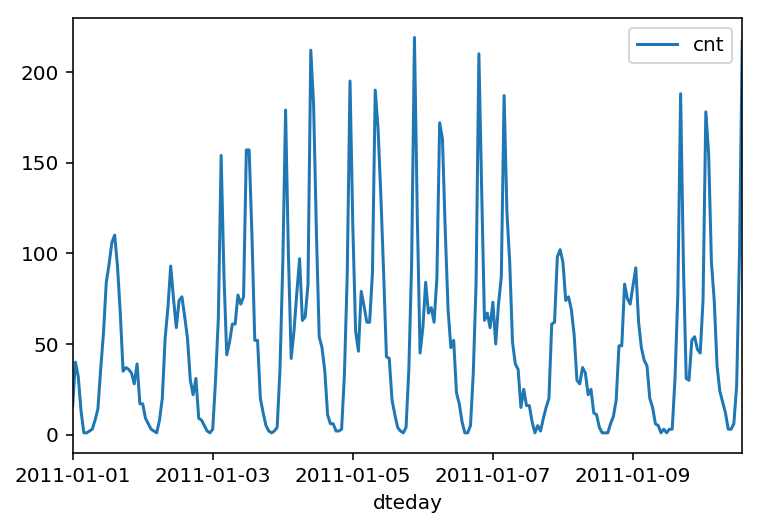

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [15]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        # NOTE: This weights are initalized differently than what we have seen up on till now in the 
        # explanations, they are 'translated' from the usual.
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.activation_prime = lambda x: self.activation_function(x)*(1-self.activation_function(x))
        
    def train(self, inputs_list, targets_list):
        # All "shapes" presuppose that inputs_list is a 56 element array 

        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T # shape: (56, 1) 
        targets = np.array(targets_list, ndmin=2).T # shape: (1, 1)
        
        
        # self.weights_hidden_to_output.shape => (1, 28) => (output , hidden)
        # self.weights_input_to_hidden => (28, 56) => (hidden, input)
        
        
        
        ######## Forward pass ########
        
        # By "dotting" weights_input_to_hidden with inputs we get the inputs to the hidden layer
        # the reason we are dotting the weights with the inputs and not the other way is because of
        # how the weights were initialized "(hidden_nodes, input_nodes)". If it had been the other
        # way, as in all examples up on till now, we could have executed the dotting operation the other
        # way.
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # shape => (28, 1)
        

        # hidden_ouputs is simply the result of applying the activation function to each and every input. 
        # This can be visualized as an array containing the outputs of each hidden unit (as for current
        # hyperparameters: 28 in total)
        hidden_outputs = self.activation_function(hidden_inputs) # shape => (28, 1)

        
        # again, we are dotting weight with inputs and not the other way around because of the ways 
        # the weights were initialized.
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # shape => (1, 1)
                        
        
        # since the activation function of the output layer is simply the identity function (as 
        # specified in the requirements) the output of the output layer is simply its input.
        final_outputs = final_inputs # shape => (1, 1)

        
        
        ######## Backward pass ########
        
        # Here I'll change the naming convention of the layers we have used up to now because it is a bit 
        # confusing for me. The changes I will make are:
        # - layer_0 => this is the input layer
        # - layer_1 => this is the hidden layer 
        # - layer_2 => this is the output layer
        # Regardless of the change of name the functionality is still the same.
        
        
        # layer_2_delta (error) is the measure of how much our prediction missed the target and of how much we have
        # to change our prediction to make it correct. If it is a positive error then our prediction was to 
        # low (so we have to make it higher), and if it is a negative value then our prediction was to high
        # and we have to make it lower.
        layer_2_delta = targets - final_outputs # shape => (1, 1)
                        

        # The following is the gradient (derivate) of the error:  
        # since activation function of output is f(x) = x it's derivate is 1
        # With "gradient" we are getting an "approximation" of how much we have to change the output value
        # and the direction in which we have to do it
        layer_2_gradient = layer_2_delta * 1 # shape => (1, 1)

        
        # Now, we have to know how much each hidden unit affects our final output. The way we do this
        # is by multiplying the layer_2_gradient (error and direction) by the weights that go from the hidden units
        # to the output unit. This gives us an idea of what effect (how much) the input associated with a weight affects 
        # the output. For example: if a weight is 0 then it's input doesn't affect at all the output.
        # Multiplying the gradient by the weights_hidden_to_output gives us a (1, 28) matrix where each value represents 
        # how much the output of one of our 28 hidden units affects the final prediction. 
        # In other words this matrix represents the error value for every hidden node.
        layer_1_errors = layer_2_gradient * self.weights_hidden_to_output # shape => (1, 28)
        layer_1_grad = (hidden_outputs * (1 - hidden_outputs)) * layer_1_errors.T # shape => (28, 1) =? change of shape is because "layer_1_errors.T"

        
        # Finally we calculate the deltas by which we have to change our weights, notice that we end up with matrices of the
        # same size as our original weight matrices so later we can go ahead and simply add (+) this deltas to our matrices and
        # numpy will take care of doing an elementwise summation.
        # With current hyperparameters:
        # - self.weights_hidden_to_output.shape => 1 to 2 => (1, 28)   
        # - self.weights_input_to_hidden.shape  => 0 to 1 => (28, 56)
        # 
        # When we had a 2 layer (input and output) network with mutiple inputs and one output the way we calculated our delta-weights was
        # by multiplying the error of the ouput with every input. This is the same thing we are doing here. We are using the
        # outputs of the hidden layers because those would be the "inputs" to the output layer. Since we only have one output
        # layer this can be visualized as a scalar-vector multiplication in which we multiply the error by the output of each
        # hidden unit and end up with a vector of all delta-weights for weights_hidden_to_output.
        # We are translating hidden_outputs so we end up with a (1, 28) matrix (which is the same shape as self.weights_hidden_to_output)
        # that we can simply go ahead and add (+) to our weights (self.weights_hidden_to_output)
        delta_1_to_2 = layer_2_gradient * hidden_outputs.T # shape => (1, 28) # (output, hiddens)

        
        # Now we calculate delta-weights for weights_input_to_hidden
        # We can treat the network as if it was a 2 layer network with multiple inputs and multiple outputs. We proceed by multiplying
        # the errors we obtained, which has a shape of (28, 1), times the translation of the inputs, which has a shape (1, 56).
        # The reason we are translating is so we can multiply (28, 1) with (1, 56), this comes to be a series of scalar-vector
        # mutliplications where each row is the multiplication of the error of a hidden unity by all the inputs.
        delta_0_to_1 = np.dot(layer_1_grad, inputs.T) # shape => (28, 56) # (hiddens, inputs)

        
        # Finally we update the weights with the calculated delta scaled by the learning rate
        self.weights_hidden_to_output += self.lr * delta_1_to_2
        self.weights_input_to_hidden += self.lr * delta_0_to_1

        
    
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = final_inputs # Activation func is identity func so we simply output the input
        
        return final_outputs

In [16]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

### How I found good hyperparameters:
To find a good set of hyperparameters I constructed an array of each value I thought of as 'sensible' for each hyperparameter, `p_epochs`, `p_learning_rate`, and `p_hidden_nodes`. Using the [`product`](https://docs.python.org/3/library/itertools.html#itertools.product) function provided by `itertools` I constructed  an array of all possible combination of my pre-selected arrays of hyperparameters. I ran the code cell below using each of these combinations and, after training was done, I appended a map with the hyperparameters, train loss, and validation loss to a `score` array. After all possible combinations were tested I obtained the result with the lowest `val_loss`.

```
p_epochs = [100, 1000, 2000, 3000] 
p_learning_rate = [0.1, 0.01, 0.001]
p_hidden_nodes = [28, 32, 64, 80, 128, 210, 256]
scores = []

import itertools
for epochs, learning_rate, hidden_nodes in itertools.product(p_epochs, p_learning_rate, p_hidden_nodes):
    # Run cell below with each of this hyper parameters and append to scores the relevant information
    # .... code in cell ....
    scores.append({'params' : {'epochs': str(epochs), 
                               'learning_rate': str(learning_rate), 
                               'hidden_nodes': str(hidden_nodes)},
                   'train_loss': str(train_loss),
                   'val_loss': str(val_loss)})
```

In [19]:
%%time
import sys

### Set the hyperparameters here ###
epochs = 7000
learning_rate = 0.01
hidden_nodes = 28
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Epoch: " + str(e) \
                     + " ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5] \
                     + " ... Learning Rate: " + str(network.lr))
    
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
            
print("\nDone training!")

Progress: 99.9% ... Epoch: 6999 ... Training loss: 0.048 ... Validation loss: 0.162 ... Learning Rate: 0.01
Done training!
Wall time: 8min 36s


(-0.0032760403960553908, 0.5)

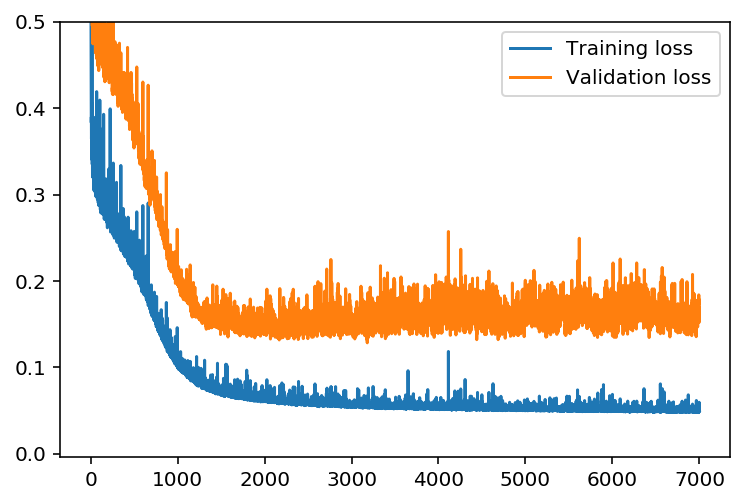

In [20]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

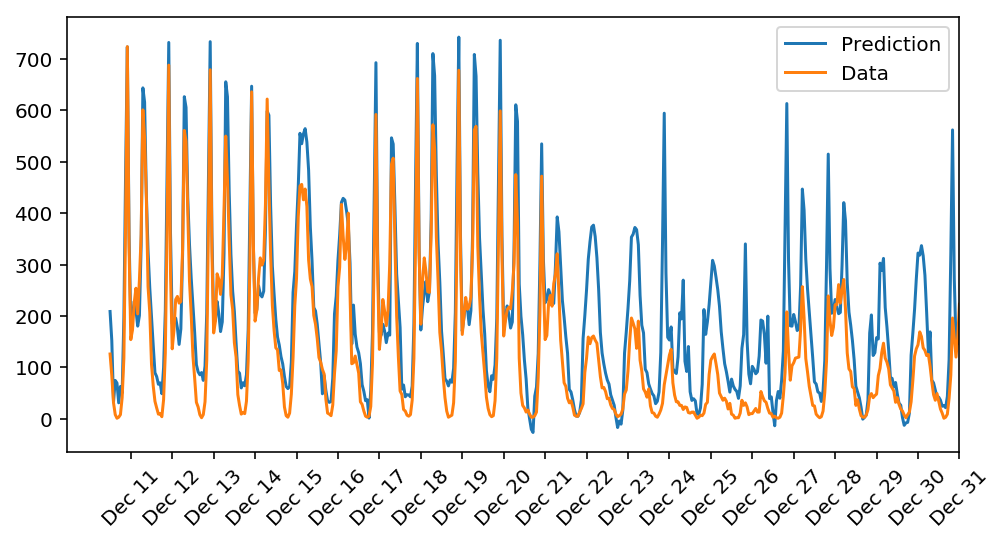

In [21]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()
    
dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
 The network actually models the data pretty well since the spikes in usage are correctly predicted at the appropiate times (hours), data shape fits well: downward and upward movement in data are mostly predicted in the right places; the problem is the scale of the prediction since it is mostly too high (maybe we could reduce this error by the introduction of a bias?).
 
 A possible reason for the error is because some input data is not very specific, and some inputs like the price of gas and world events are not taken into account. As an example of the first case, "weathersit" has 4 possible values which might be too general: for weathersit_3 I could imagine someone using a bike in "Light Rain + Scattered clouds" but it might be less likely that they would use one in "Light Rain + Thunderstorm + Scattered clouds". Also, the kind of holiday is not specified since there are some that are more of a family holiday and others that are more of a 'get out' holiday (probably this doesn't affect much since there aren't that many holidays). An exaple of untracked events is, as the dataset's Readme says, hurricane Sandy on 2012-10-30.

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [22]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.032s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>